<a href="https://colab.research.google.com/github/smartgeometry-ucl/COMP0169-2021-CourseWorks/blob/master/CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 1: Learning Learning, From Scratch
_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Luca Morreale, Pradyumna Reddy, Sanjeev Muralikrishnan & Animesh Karnewar__

The total points for this exercise is 100.

Please refer to Moodle submission page for the due date.


## Submission:

Coursework submissions must comprise of this **single** jupyter notebook, containing your code and written comments. Cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any way. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#begin_solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated.

Please, do not change `#begin_test ... #end_test` blocks.

Each exercise must be implemented from scratch. Unless differently specified, only numpy and matplotlib are allowed. The libraries are imported in [the package cell](#packages) and cannot be modified.

Note: The `optimize` module from `scipy` can only be used for the question where it is specified, and not anywhere else.



**Questions:**

[Question 1](#question1): Linear Fitting (10 points)

[Question 2](#question2): Free form optimization (18 points)

[Question 3](#question3): Clustering (14 points)

[Question 4](#question4): Linear Classification (18 points)

[Question 5](#question5): Non-linear Classification (20 points)

[Question 6](#question6): Neural Networks (20 points)

## Datasets

We will be using two datasets for the whole coursework: _IRIS_ and _MNIST_. Both datasets will be downloaded directly in the notebook using the `skdataset` library. Keep in mind that you will need to be connected to Internet to be able to download the datasets. If you want to work offline, you are free to save your dataset to npy file locally and load them while offline although this is not officially supported.

**_IRIS_**: The _IRIS_ dataset contains the following features in order: _sepal length_, _sepal width_, _petal length_, _petal width_. Classes names are: __Iris Setosa__ for label **0**, __Iris Versicolour__ for label **1**, and __Iris Virginica__ for label **2**.

**_MNIST_**: _MNIST_ is a dataset composed of images of handwritten digits. The features of each image are the pixels themselves.

The script will generate two subsets for each of the two datasets, a training subset (**X\_dataset** and **Y\_dataset** with **dataset** the name of the dataset) and a test subset (**X\_dataset\_test** and **Y\_dataset\_test**).

We will test correctness of your code on _Hidden_ set.

**Warning:** as _Hidden_ may have different dimensions from _IRIS_ and _MNIST_, hard-coded solutions may not work, thus resulting in lower grades. You need to make sure that your code would work if applied on a different number of samples and a different number of features/pixels.

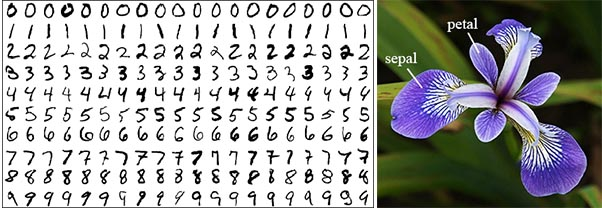

## Packages

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [1]:
# Importing packages
import numpy as np
import random

import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Setting the seed
RAND_ST = 42
random.seed(RAND_ST)
#begin_test

#end_test


## Data Loading

The following cells are used to load both datasets, _Iris_ and _MNIST_.

In [3]:
def load_iris_dataset(num_classes=2):
    # Load the datadet from SkDataset
    iris = skdataset.load_iris()
    X = iris.data
    Y = iris.target
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [4]:
def load_mnist_dataset(num_classes=2):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

def load_mnist_dataset_onevsall(class_id=7):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # One versus all
    idx = Y == class_id
    Y[~idx] = 0
    Y[idx]  = 1
    return X, Y

## Functions for visualization

In [5]:
def plot_dataset(X, Y, dims=[0,1]):
    # Keep only two dimensions
    X_reduced = X[:, dims]
    # Plot the data points
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap=plt.cm.Set1, edgecolor='k')
    plt.xlabel('Feat 1')
    plt.ylabel('Feat 2')
    plt.show()

In [6]:
def plot_correlation(X1, X2):
    # Plot both variables
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X1, X2, edgecolor='k')
    line = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 20)
    plt.plot(line, line, 'r')
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.show()

In [7]:
def plot_eigenvecs(stacked_images, n_rows, n_columns):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]))
        plt.axis('off')
    plt.show()

def plot_grey_image(stacked_images, n_rows, n_columns, titles):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if len(titles) == n_rows*n_columns:
          plt.title(titles[i])
    plt.show()

In [8]:
def plot_loss_curve(logs):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(logs)
    plt.show()

In [9]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

## Data Loading

In the following cells, the dataset is created with proper splits between training and test set.

_IRIS_ dataset

In [10]:
X, Y = load_iris_dataset(num_classes=3)
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

_MNIST_ dataset

In [11]:
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

## 1. Linear Fitting (10 points)
<a name='question1'></a>

[a)](#question1a) Implement the normal equation solver function **nsolve**, which takes as input the matrix **X** and the target vector **y** and returns the optimized weights **w**. Test your code with your own mockup data. (**5 points**)

[b)](#question1b) Implement **line_fit(X,y)** which should fit a linear function to the input data. Test your implementation on the following task: predict with linear fitting the _petal length (cm)_ of the Iris dataset using the three remaining variables as inputs (_sepal length (cm)_, _sepal width (cm)_ and _petal width (cm)_). Report the L2 loss on the validation set and plot a graph showing the correlation between y and your prediction on the test set. (**2 points**)

[c)](#question1c) Implement **poly_fit(X,y)** which should fit a 2nd degree polynomial to the input data. Test your implementation on the following task: predict with the polynomial the petal width (cm) of the _IRIS_ dataset using the three remaining variables as inputs (sepal length (cm), sepal width (cm), petal length (cm)). The 2nd degree polynomial should consider all possible pairwise terms, i.e. $w_1x^2 + w_2xy+ w_3y^2 + w_4x+ w_5y+ w_6$ in the case of two input variables $x$ and $y$. Report the L2 loss on the validation set and plot a graph showing the correlation between $y$ and your prediction on the test set. (**3 points**)

**Question 1.a**
<a name='question1a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [12]:
def nsolve(X,y):
    """
    Write your implementation of nsolve here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights 
    """

    #begin_solution
    
    # The equation for a normal equation solver is W = inv(X.T @ X) @ X.T @ Y
    return np.linalg.inv(np.transpose(X) @ X) @ np.transpose(X) @ y

    #end_solution


    return w

Testing your code on mockup data.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [13]:
"""
After implementing nsolve, test it below on some mock data using np.random
"""

#begin_solution
X = np.random.rand(3, 3)
w = np.random.rand(3)
e =  0.000001

y = X @ w

flag = True
ns_W = nsolve(X, y)  # ns_W is the w returned by the solver

# for every element in the w list, verify if the difference between the
# value from solver and the real value is greater than an epsilon treshold
for i, ns_wi in enumerate(ns_W):
  if (ns_wi - w[i]) ** 2 >= e:
    flag = False

print(flag)

#end_solution


True


**Question 1.b**
<a name='question1b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [14]:
def line_fit(X,y):
    """
    Write your implementation of line_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 Prediction error using learned w
    """

    #begin_solution

    w = nsolve(X, y)
    y_predicted = X @ w

    # l2_error is the sum of the squared differences between
    # the predicted values and target values
    l2_error = np.sum((y - y_predicted) ** 2)

    #end_solution


    return w, l2_error

Testing your code on _IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [15]:
"""
After implementing line_fit, test it below on IRIS Train set.
Print the L2 error on the Training set.
"""

#begin_solution

# extracting the petal length attributes
petal_length = X_iris[:,3]

# extracting the other attributes
iris_attributes = X_iris[:, [0, 1, 2]]

# adding a "1" value that represents the bias
iris_attributes = np.column_stack([np.ones([len(iris_attributes), 1]),\
                                   iris_attributes.reshape(-1, 3)])

w, l2_error = line_fit(iris_attributes, petal_length)

print(l2_error)

#end_solution


4.657355666940582


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [16]:
"""
After implementing line_fit, test it below on IRIS Test set.
Print the L2 error with respect to Test set.
"""

#begin_solution

x_test = X_iris_test[:, [0, 1, 2]]

# adding a "1" value that represents the bias
x_test = np.column_stack([np.ones([len(x_test), 1]), x_test.reshape(-1, 3)])

y_test = X_iris_test[:, 3]

y_predicted = x_test @ w

l2_error = np.sum((y_test - y_predicted) ** 2)

print(l2_error)

#end_solution


0.7405652915921062


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

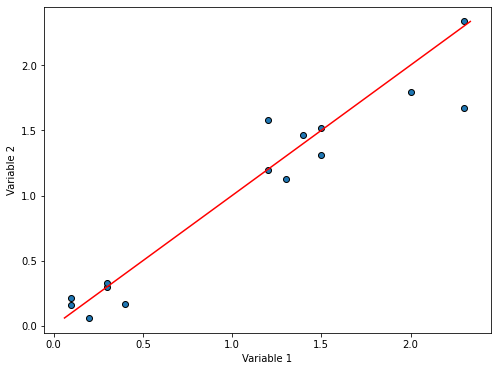

In [17]:
"""
Below, plot and display the correlation between true y and predicted values.
"""
#begin_solution
plot_correlation(y_test, y_predicted)
#end_solution


In [18]:
#begin_test

#end_test


**Question 1.c**
<a name='question1c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [19]:
def poly_fit(X,y):
    """
    Write your implementation of poly_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 prediction error using learned w
    """

    #begin_solution
    # in order to cover all possible combinations, the equation is:
    # w0 + w1 * x1^2 + x2^2 + x3^2 + x1 * x2 + x1 * x3 + x2 * x3 + x1 + x2 + x3 
    X = np.column_stack([np.ones([len(X), 1]),
                      X[:, 0] ** 2,
                      X[:, 1] ** 2,
                      X[:, 2] ** 2,
                      X[:, 0] * X[:, 1],
                      X[:, 0] * X[:, 2],
                      X[:, 1] * X[:, 2],
                      X[:, 0],
                      X[:, 1],
                      X[:, 2]])
    
    w = nsolve(X, y)
    y_predicted = X @ w

    l2_error = np.sum((y - y_predicted) ** 2)
    
    #end_solution


    return w, l2_error

Testing your code on _IRIS_.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [20]:
"""
After implementing poly_fit, test it below on IRIS Training set.
Print L2 error with respect to training set.
"""

#begin_solution
petal_length = X_iris[:,3]
iris_attributes = X_iris[:, [0, 1, 2]]

w, l2_error = poly_fit(iris_attributes, petal_length)

print(l2_error)

# print(xx)
#end_solution


4.182175045904069


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [21]:
"""
After implementing poly_fit, test it below on IRIS Test set.
Print L2 error with respect to test set.
"""

#begin_solution
l2_error = 0
x_test = X_iris_test[:, [0, 1, 2]]
y_test = X_iris_test[:, 3]

# modelling the X to correspond to the equation:
# w0 + w1 * x1^2 + x2^2 + x3^2 + x1 * x2 + x1 * x3 + x2 * x3 + x1 + x2 + x3 
x_test = np.column_stack([np.ones([len(x_test), 1]),
                      x_test[:, 0] ** 2,
                      x_test[:, 1] ** 2,
                      x_test[:, 2] ** 2,
                      x_test[:, 0] * x_test[:, 1],
                      x_test[:, 0] * x_test[:, 2],
                      x_test[:, 1] * x_test[:, 2],
                      x_test[:, 0],
                      x_test[:, 1],
                      x_test[:, 2]])

y_predicted = x_test @ w

l2_error = np.sum((y_test - y_predicted) ** 2)

print(l2_error)
#end_solution


0.7433600971655396


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

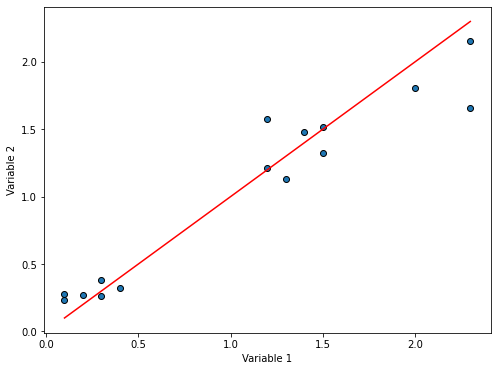

In [22]:
"""
Below, plot and display the correlation between true y and predicted values
"""

#begin_solution
plot_correlation(y_test, y_predicted)
#end_solution


In [23]:
#begin_test

#end_test


## 2. Free form optimization (18 points)
<a name='question2'></a>

[a)](#question2a) Implement Gradient Descent (GD) (**3 points**), Gradient Descent with Nesterov Momentum (GDN)  (**4 points**) and a second order optimization method (**4 points**)

[b)](#question2b) Write the gradient and hessian of "paraboloid" and run the optimization methods on it (**7 points** on hidden test)

**Question 2.a**
<a name='question2a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [24]:
def gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change=1.0e-6):
    """
    Write your own implementation of gradient descent here.
    
    Arguments:
    
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     derivative of the function to minimize - R^N -> R^N
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    
    #begin_solution

    for current_it in range(max_iterations):
      dmin = d_objective(parameters)
      minimizer = parameters - [step_size * x for x in dmin]

      # if the parameters do not improve more than an epsilon treshold, stop
      if np.sum((minimizer - parameters) ** 2) < eps_change ** 2:
        break
      
      parameters = minimizer

    #end_solution

        
    return minimizer, current_it + 1
    

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [25]:
def gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change):
    """
    Write your own implementation of gradient descent with Nesterov momentum here.
    
    Arguments:
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     derivative of the function to minimize - R^N -> R^N
    momentum:        weight of the momentum term - R^1
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    v = np.zeros(parameters.shape)
    
    #begin_solution

    for current_it in range(max_iterations):
      dmin = d_objective(parameters + momentum * v)
      minimizer = parameters - [step_size * x for x in dmin]
      v = momentum * v  - [step_size * x for x in dmin]
      minimizer = parameters + v

      # if the parameters do not improve more than an epsilon treshold, stop
      if np.sum((minimizer - parameters) ** 2) < eps_change ** 2:
        break
      
      parameters = minimizer

    #end_solution

        
    return minimizer, current_it + 1
    

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [26]:
def second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change):
    """
    Write your own implementation of a second order optimizer.
    
    Arguments:
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     function computing the derivative of the objective - R^N -> R^N
    dd_objective:    function computing the second derivative of the objective - R^N -> R^NxN
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    
    #begin_solution
    for current_it in range(max_iterations):
      dmin = np.linalg.inv(dd_objective(parameters)) @ d_objective(parameters)
      minimizer = parameters - [step_size * x for x in dmin]

      # if the parameters do not improve more than an epsilon treshold, stop
      if np.sum((minimizer - parameters) ** 2) < eps_change ** 2:
        break
      
      parameters = minimizer

    #end_solution

        
    return minimizer, current_it + 1
    

In [27]:
def square(X):
    return np.power(X, 2).sum()

def d_square(X):
    return 2 * X

def dd_square(X):
    hessian = np.eye(X.shape[0]) * 2
    return hessian

**Question 2.b**
<a name='question2b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [28]:
def paraboloid(X): # paraboloid or saddle function X[0]^2-X[1]^2+X[2]^2 ... 
    tmp = np.power(X, 2)
    return tmp[0::2].sum() - tmp[1::2].sum()

def d_paraboloid(X):
    gradient = np.zeros(X.shape[0])
    #begin_solution
    gradient = [2.0 * x if i % 2 == 0 else -2.0 * x for i, x in enumerate(X)]
    #end_solution

    return gradient

def dd_paraboloid(X):
    hessian = np.eye(X.shape[0])
    #begin_solution
    for i in range(X.shape[0]):
      if i % 0 == 2:
        hessian[i][i] = 2
      else:
        hessian[i][i] = -2
    #end_solution

    return hessian

In [29]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [30]:
parameters     = np.ones(1)
objective      = square
d_objective    = d_square
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

gd_minimizer, gd_it = gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change)

#begin_test

#end_test


parameters     = np.ones(1)
objective      = square
d_objective    = d_square
momentum       = 0.4
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

nesterov_minimizer, nesterov_it = gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change)

#begin_test

#end_test


parameters     = np.ones(1)
objective      = square
d_objective    = d_square
dd_objective   = dd_square
step_size      = 1.0
max_iterations = 200
eps_change     = 1.0e-6

second_minimizer, second_it = second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change)

#begin_test

#end_test



&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [31]:
parameters     = np.ones(1)
objective      = paraboloid
d_objective    = d_paraboloid
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

gd_minimizer, gd_it = gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change)

#begin_test

#end_test


In [32]:
#begin_test

#end_test


## 3. Clustering (14 points)
<a name='question3'></a>

[a)](#question3a) Implement a function pca(X, ndims) that performs PCA over the input data X and returns both the mean vector  ̄X and the ndims top components. The top components are the eigen vectors linked to the top eigen values computed from the covariance matrix. Try your function on the _MNIST_ dataset, which is composed of 10 digit classes. Display the top 10 components fitted on the train dataset as images. Next, check that you can reconstruct perfectly an input digit from the test set using all components, by implementing pca_projection(X, mean_vec, eig_vecs) and pca_reconstruction(weights, mean_vec, eig_vecs). (**3 points** + **4 points** on hidden dataset)

[b)](#question3b) Perform independent research on the clustering algorithm k-means. Implement a function kmeans performing k-means on input data X. Propose the interface to that function (i.e., what is its input and output?) and write in three sentences why this is. Apply you kmeans implementation on the _MNIST_ training set with k= 10 clusters and display the centroids as images. (**2 points** + **3 points** on hidden dataset)

[c)](#question3c) Describe the k-means algorithm, highlighting similarities and differences from PCA. Compare the reconstruction loss on the validation set for both k-means and PCA. Write no more than ten sentences. (**2 points**)

**Question 3.a**
<a name='question3a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [33]:
def pca(X, ndims):
    """
    Write your implementation of PCA here.

    Arguments:
    X : Data matrix
    ndims : Number of reduced dimensions

    Returns:
    mean_vec : Data mean
    top_eig_vecs : Selected eigen vectors, a matrix where each column corresponds
                    to an eigen vector
    """

    #begin_solution
    mean_vec = np.mean(X, axis=0)
    X_standardized = X - np.mean(X, axis=0)
    cov_mat = np.transpose(X_standardized) @ X_standardized

    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

    # the eigen_values are in ascending order, therefore we want to extract
    # the last ndims vectors associeted with this values
    top_eig_vecs = eigen_vectors[:, -ndims:]
    #end_solution


    return mean_vec, top_eig_vecs

Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

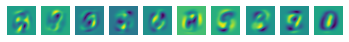

In [34]:
"""
Below, test your PCA on  MNIST dataset.
Plot and display the selected eigen vectors returned by PCA.
"""

#begin_solution
mean_vec, top_eig_vecs = pca(X_mnist, 10)

plot_eigenvecs(np.transpose(top_eig_vecs), 1, 10)

#end_solution


In [35]:
#begin_test

#end_test


Now, we can evaluate if the code is working properly by projecting the first image of the test set on the eigen vectors.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>


In [36]:
def pca_projection(X, mean_vec, eig_vecs):
    """
    Write your implenetation of PCA projection here.

    Arguments:
    X : Data matrix
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector

    Returns:
    weights : Weights corresponding to the eigen vectors
    """

    #begin_solution
    weights = np.dot((X - mean_vec), eig_vecs)
    #end_solution


    return weights

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [37]:
def pca_reconstruction(weights, mean_vec, eig_vecs):
    """
    Write your implementation of PCA reconstruction here.

    Arguments:
    weights : Weights obtained from pca_projection
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector
    """

    #begin_solution
    reconstruction = np.dot(weights, np.transpose(eig_vecs)) + mean_vec
    #end_solution


    return reconstruction

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

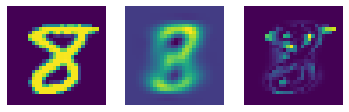

In [38]:
"""
Below, 
1. Perform  PCA on MNIST training set, without reducing dimensions.
2. Project the first image of Test set to the eigen vectors using pca_projection.
3. Reconstruct that image using pca_reconstruction.
4. Display side-by-side, the Test image, its projection and the 
   pixelwise difference between the two. Use the plotting functions provided.
"""

#begin_solution

mean_vec, top_eig_vecs = pca(X_mnist, 10)

# getting the weights of the first image projection
w_projected = pca_projection(X_mnist_test[0], mean_vec, top_eig_vecs)

# getting the reconstructed image
x_reconstructed = pca_reconstruction(w_projected, mean_vec, top_eig_vecs)

# getting the differece between the reconstructed image and the initial image
x_diff = (X_mnist_test[0] - x_reconstructed) ** 2

# plotting side by side the initial image, it's reconstruction and difference
plotted_matrix = np.array([X_mnist_test[0], x_reconstructed, x_diff])

plot_eigenvecs(plotted_matrix, 1, 3)


#end_solution


**Question 3.b**
<a name='question3b'></a>

&#9998; <font>
I propose that the input of the kmeans function should be X, C, k, max_iterations. The added C is a list of initial centroids, each centroid being randomly extracted from a pool of points with the same label (in our exact situation, 10 centroids that represent points corresponding to each label from 0 to 9). Therefore, the algorithm will return a better answer after fewer iterations by defining valid cetroids that split the data in 10 different categories. For the output, i would return the final centroids but also a list of the corresponding centroids for every element in the dataset, because it is usualy useful in further steps of the programme, and the sum of distances between data and centroids as it reflects the accuracy of the algorithm.
</font>

_Your reply:_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [39]:
#begin_test

#end_test


In [40]:
def kmeans(X, k, max_iterations=1000):
    """
    Write your implementation of kmeans here.

    Arguments:
    X : Data matrix.
    k : Your choise of k, an integer.
    max_iterations : The number of iterations after which to stop.

    Returns:
    centroids: The learned cluster centroids.
    """

    #begin_solution

    best_centroids = None
    redo_centroids_max = 2
    best_centroids_distance = -1.0
    flag = False

    # redo_centroids_max is the number of times we randomly pick
    # a set of centorids and run the algorithm again. I suggest a number of
    # at least 10 iterations, but for a decent computational time I run it with
    # a number of 2 iterations - just to exemplify the process
    for iter in range(redo_centroids_max):
      c_list = []  # list with idices from data matrix for selected centroids
      for i in range(k):
        new_random = int(np.random.uniform(0, len(X)))
        while new_random in c_list:  # avoid picking the same centroid twice
          new_random = int(np.random.uniform(0, len(X)))
        
        c_list.append(new_random)
      
      # create a numpy array with centroids corresponding to the indices
      centroids = np.zeros([k, X.shape[1]])
      for i in range(centroids.shape[0]):
        centroids[i] = X[c_list[i]]

      old_labels = np.zeros(X.shape[0])
      step = 0

      # recalculating the centroids by a maximum interation times
      for step in range(max_iterations):
        labels = np.zeros(X.shape[0])  # associated centroid for data

        # list of the sum of data associated to every centroid
        centroids_sum = np.zeros_like(centroids)

        # list of the number of associated points for every centroid
        centroids_counter = np.zeros(k)

        for i, img in enumerate(X):
          min_distance = float('inf')
          min_centroid = 0

          # getting the closest centroid to the data
          for j, centroid in enumerate(centroids):
            distance = np.sum((img - centroid) ** 2)
            if distance < min_distance:
              min_distance = distance
              min_centroid = j

          # assign the correspondance between data and centroid
          labels[i] = min_centroid
          centroids_sum[min_centroid] += img
          centroids_counter[min_centroid] += 1
        
        # if there's no change regarding the label associated to data, stop
        if np.sum((labels - old_labels) ** 2) == 0:
          break

        # setting the new centroids as the mean of their associated data
        centroids = np.copy(centroids_sum)
        for i in range(centroids.shape[0]):
          centroids[i, :] /= centroids_counter[i]
        
        old_labels = labels
      
      # after setting the final centroids, the sum of distances between points
      # and their associated centroid is computed.
      total_centroids_distance = 0
      for i, img in enumerate(X):
        distance_to_centroid = np.sum((img - centroids[int(labels[i])]) ** 2)
        total_centroids_distance += distance_to_centroid
      
      # As this sum should me minimized, we choose to keep the centroids that
      # produce the smallest sum
      if total_centroids_distance < best_centroids_distance or best_centroids_distance == -1.0:
        best_centroids = np.copy(centroids)
        best_centroids_distance = total_centroids_distance

    centroids = best_centroids

    #end_solution


    return centroids

Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

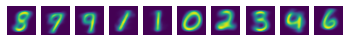

In [41]:
"""
Below, test your kmeans on the MNIST dataset.
For all 10 digits, plot and display the cluster centroids as an image grid. 
Use provided plotting functions.
"""

#begin_solution

centroids = kmeans(X_mnist, 10, 25)
plot_eigenvecs(centroids, 1, 10)

#end_solution


**Question 3.c**
<a name='question3c'></a>

&#9998; <font>
K-means algorithm consists in picking k centroids that help labelling the data in k categories. Having data represented as points in n dimensions, the goal is to find points that represent centers for specific labels. First, we have to randomly pick centroids from the input data. After that, we have to run the algorithm until a maximim iteration treshold is met, or until the is almost no change in labelling the input data. During an iteration, we calculate the closest centroids for every input data, and after that we calculate the mean of data associated with every centroid. The new centroids would be the means associated with every centroid. For better results, we run this algorithm multiple times with different initial centroids, untild the distance between data and centroids is minimized.
Similar to the PCA, K-means is based on minimizing the distance between input data and prediction. However, in PCA the prediction is composed of eigenvectors that define the data space reduced in dimensions, while in K-means the prediction is composed of K points that act as centroids. The reconstruction loss is smaller once we pick a higher number of dimensions for the PCA. For K-means, the optimization comes from picking better initial centroids and having as many clusters as possible outputs, in MNIST case, 10.
</font>

_Your reply_:

In [42]:
#begin_test

#end_test


## 4. Linear Classification (18 points)
<a name='question4'></a>

[a)](#question4a) Implement the normal equation-based binary linear classifier lclass(examplesA, examplesB, testExamples) where the first two arguments are the set of samples from class A and class B respectively and the third is the test. The function should return a vector of 0s and 1s, 0 if test is in A and 1 otherwise. It should, for simplicity, both train and test in one function call. (**3 points**)
Test this on all the samples in _IRIS_, Setosa vs non-Setosa, etc and propose a simple analysis (text, figure, table) of the result you find, but not longer than ten sentences. (**4 points** on hidden dataset)

[b)](#question4b) Perform independent research how to do multi-class classification. Implement lclass_prob(examplesA, examplesB, testExamples) and lmclass(examples, class, testExamples) that together perform multi-class classification of the examples examples according to the vector of labels class of the same size and test it with testExamples by returning a matrix, where each row expresses the probability of a sample in testExamples to belong to each class. Give the accuracy of your model. (**5 points** + **6 points** on hidden dataset)
Present findings applying multi-class classification on _IRIS_ dataset with 3 classes. You can include figures and tables if needed. Write no longer than ten sentences.

**Question 4.a**
<a name='question4a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [43]:
def lclass(examplesA, examplesB, testExample):
    """
    Write your implementation of normal equation based linear classifier here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted 0/1 labels on testExample
    """

    #begin_solution

    # setting -1 label for A and 1 label for B
    Y_examplesA = np.full(examplesA.shape[0], -1)
    Y_examplesB = np.ones(examplesB.shape[0])

    X_all = np.concatenate((examplesA, examplesB))
    Y_all = np.concatenate((Y_examplesA, Y_examplesB))

    # having X and Y, we compute W such as X @ W = Y
    w = nsolve(X_all, Y_all)
    
    predicted = []

    for test in testExample:
      # calculating the predicted value. If it's positive, assign 1, otherwise 0
      prediction = np.transpose(w) @ test
      if prediction < 0.0:
        predicted.append(0)
      else:
        predicted.append(1)

    #end_solution


    return predicted

_IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Setosa vs non-setosa classification:
[1 0 1 1 1 0 1 1 1 1 1 0 0 0 0]
[1 0 1 1 1 0 1 1 1 1 1 0 0 0 0]
Versicolour vs non-versicolour classification:
[0 1 0 1 0 1 1 1 0 1 1 1 1 1 1]
[0 1 1 0 0 1 0 1 0 0 1 1 1 1 1]
Virginica vs non-virginica classification:
[1 1 0 0 1 1 1 0 1 1 0 1 1 1 1]
[1 1 0 1 1 1 1 0 1 1 0 1 1 1 1]
Plot of data


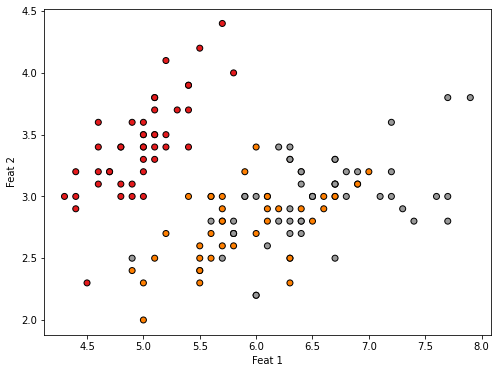

We can observe that a separator can be traced between all the  red points and all the others.
However it is impossible to perfectly  separate blue points from the orange ones, resulting in imperfect results in  the linear classification for the orange or blue points.  
Therefore, we can observe a perfect prediction for setos vs non-setos,  But a slightly wrong prediction for cersicolour, having 4 digits wrong.  
The prediction for virginica is also slightly wrong having only one digit miscalculated


In [44]:
"""
After implementing lclass, test it below on the IRIS dataset.
"""

#begin_solution

# for every type of iris perform one vs all classification
X_setosa = X_iris[Y_iris == 0]
X_setosa_other = X_iris[Y_iris > 0]

X_versicolour = X_iris[Y_iris == 1]
X_versicolour_other = X_iris[Y_iris != 1]

X_virginica = X_iris[Y_iris == 2]
X_virginica_other = X_iris[Y_iris < 2]

# predict one vs all classification for every type of iris
predicted_setosa = lclass(X_setosa, X_setosa_other, X_iris_test)
predicted_versicolour = lclass(X_versicolour, X_versicolour_other, X_iris_test)
predicted_virginica = lclass(X_virginica, X_virginica_other, X_iris_test)

# set the target for every classification
Y_test_setosa = np.zeros_like(Y_iris_test)
Y_test_versicolour = np.zeros_like(Y_iris_test)
Y_test_virginica = np.zeros_like(Y_iris_test)

for i, val in enumerate(Y_iris_test):
  if val == 0:
    Y_test_versicolour[i] = 1
    Y_test_virginica[i] = 1
  elif val == 1:
    Y_test_setosa[i] = 1
    Y_test_virginica[i] = 1
  else:
    Y_test_setosa[i] = 1
    Y_test_versicolour[i] = 1

print('Setosa vs non-setosa classification:')
print(np.array(predicted_setosa))
print(Y_test_setosa)

print('Versicolour vs non-versicolour classification:')
print(np.array(predicted_versicolour))
print(Y_test_versicolour)

print('Virginica vs non-virginica classification:')
print(np.array(predicted_virginica))
print(Y_test_virginica)

print('Plot of data')
plot_dataset(X_iris, Y_iris)
print("We can observe that a separator can be traced between all the \
 red points and all the others.\nHowever it is impossible to perfectly \
 separate blue points from the orange ones, resulting in imperfect results in \
 the linear classification for the orange or blue points. \
 \nTherefore, we can observe a perfect prediction for setos vs non-setos, \
 But a slightly wrong prediction for cersicolour, having 4 digits wrong. \
 \nThe prediction for virginica is also slightly wrong having only one digit\
 miscalculated")
#end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Confusion matrix for setosa vs non-setosa prediction:


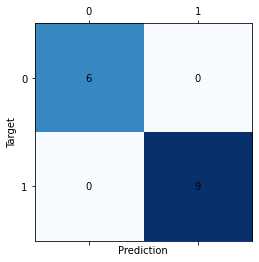

Confusion matrix for versicolour vs non-versicolour prediction:


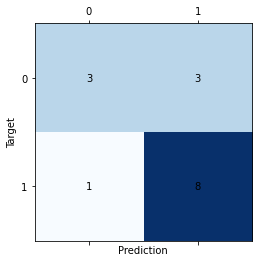

Confusion matrix for virginica vs non-virginica prediction:


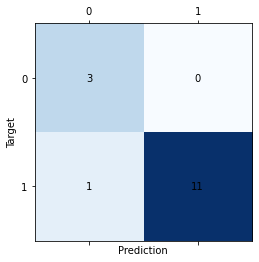

In [45]:
"""
Below, plot and display the confusion matrix of your prediction with respect to 
true values. Use provided functions for plotting.
"""

#begin_solution
print('Confusion matrix for setosa vs non-setosa prediction:')
plot_confusion_matrix(Y_test_setosa, np.array(predicted_setosa))

print('Confusion matrix for versicolour vs non-versicolour prediction:')
plot_confusion_matrix(Y_test_versicolour, np.array(predicted_versicolour))

print('Confusion matrix for virginica vs non-virginica prediction:')
plot_confusion_matrix(Y_test_virginica, np.array(predicted_virginica))

#end_solution


In [46]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

**Question 4b**
<a name='question4b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [47]:
def softmax(preds):
  """
  Write your implementation of the softmax activation here.

  Arguments:
  preds : The output predicted classes from your classifier

  Returns:
  activation : The outputs after applying softmax activation
  """

  #begin_solution

  e_sum = 0
  for p in preds:
    e_sum += np.exp(p)
  
  activation = []

  for p in preds:
    activation.append(np.exp(p) / e_sum)

  #end_solution


  return activation

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [48]:
def lclass_prob(examplesA, examplesB, testExample):
    """
    Write your implementation of lclass_prob here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted probabilities of samples in testExample belonging to a class.
    """
    
    #begin_solution 
    # This function is similar to the previous lclass, but instead of labels
    # it returns float numbers suggesting the probabilities
    Y_examplesA = np.ones(examplesA.shape[0])
    Y_examplesB = np.full(examplesB.shape[0], -1)

    X_all = np.concatenate((examplesA, examplesB))
    Y_all = np.concatenate((Y_examplesA, Y_examplesB))

    w = nsolve(X_all, Y_all)
    
    preds = []

    for test in testExample:
      prediction = np.transpose(w) @ test
      preds.append(prediction)

    #end_solution

    
    return preds

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [49]:
def lmclass(examples, labels, testExample):
    """
    Write your implementation of multiclass classifier lmclass here.
    Use your lclass_prob implementation here to solve this.

    Arguments:
    examples : The training data matrix
    labels : The training labels
    testExample : The testing data matrix

    Returns:
    preds_prob : For each sample in testExample, their predicted probabilities
                 of belonging to each class
    """

    #begin_solution

    unique_labels = np.sort(np.unique(labels))
    preds_prob = []

    # for every label perform one vs all classifier and save the probabilities
    for l in unique_labels:
      examplesA = []
      examplesB = []
      for i, label in enumerate(labels):
        if label == l:
          examplesA.append(examples[i])
        else:
          examplesB.append(examples[i])
      
      preds_prob.append(lclass_prob(np.array(examplesA), np.array(examplesB), testExample))

    preds_prob = np.transpose(preds_prob)

    # for every input from test, gen the final probabilities by applying softmax
    # on the probabilities of input to be label 0, label 1 or label 2,
    # probabilities that were extracted by doing classifiers 0 vs all,
    # 1 vs all and 2 vs all
    for i in range(preds_prob.shape[0]):
      preds_prob[i] = softmax(preds_prob[i])

    #end_solution

    
    return preds_prob

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [50]:
#begin_solution
preds_probs = lmclass(X_iris, Y_iris, X_iris_test)

print('Probability distribution for every input from the test set:')
print(preds_probs)
print('The expected labels:')
print(Y_iris_test)

correct_guess = 0
for i, y in enumerate(Y_iris_test):
  print('Expected: {}, but the expected label has a probability of {}'.format(y, preds_probs[i][y]))
  if preds_probs[i][y] > 0.5:
    correct_guess += 1

print('Accuracy: ', correct_guess / Y_iris_test.shape[0])

#end_solution


Probability distribution for every input from the test set:
[[0.17886253 0.53411379 0.28702368]
 [0.77473603 0.1465126  0.07875138]
 [0.04438695 0.5110822  0.44453085]
 [0.21116646 0.34385249 0.44498105]
 [0.1714697  0.55776199 0.27076831]
 [0.74440725 0.15792809 0.09766466]
 [0.32324554 0.27936399 0.39739046]
 [0.14216772 0.17276092 0.68507135]
 [0.13854689 0.53866255 0.32279055]
 [0.25926369 0.42083465 0.31990166]
 [0.16122908 0.20961475 0.62915617]
 [0.67629824 0.23849325 0.08520852]
 [0.77555353 0.15741047 0.067036  ]
 [0.67843119 0.23764837 0.08392044]
 [0.79726438 0.10766832 0.0950673 ]]
The expected labels:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0]
Expected: 1, but the expected label has a probability of 0.5341137886415112
Expected: 0, but the expected label has a probability of 0.7747360254545724
Expected: 2, but the expected label has a probability of 0.44453085014199223
Expected: 1, but the expected label has a probability of 0.3438524884669188
Expected: 1, but the expected label has a

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

In [51]:
#begin_test

#end_test


## 5. Non-linear Classification (20 points)
<a name='question5'></a>

[a)](#question5a) Implement classification based on logistic regression using GD by implementing the gradient function dlogistic(preds, X, Y) and optimizing using GD. preds are the prediction from the model, X are the data and Y are the labels. Propose a function interface for your implementation of the gradient descent algorithm. (**2 points** + **2 points** on hidden dataset)

[b)](#question5b) Implement classification based on hinge loss using GD by implementing the gradient function dhinge(preds,
W, X, Y) and optimizing using GD. preds are the prediction from the model, W describes the model parameters, X is the data and Y represent the labels. Propose a function interface for your implementation
of the gradient descent algorithm. (**2 points** + **2 points** on hidden dataset)

[c)](#question5c) Implement kernel SVM function ksvm(kernel, X, Y, X_test). The function takes as input a kernel function kernel, training data X, Y and a set of test points X_test. The function returns the set of support vectors along with the predicted labels. You are allowed to use scipy optimization library to solve the quadratic problem of SVM. (**5 points** + **7 points** on hidden dataset)

**Question 5.a**
<a name='question5a'></a>

In [52]:
def gd(X, Y, W,loss_function, loss_gradient, step_size, max_it):
    """
    Implement Gradient Descent here with Logistic loss and its gradient.
    Print the loss values at some interval
    of your choice.

    Arguments:
    X : Data matrix
    Y : Labels
    W : Weights, previously initialized outside this function.
    loss: A callable function that can be used as loss_function(preds,Y) 
              and returns the loss.
    loss_gradient : A callable function that can be used as loss_gradient(preds,X,Y,W=[]) 
              and returns gradient of the loss.
    step_size : Float value of step size to take.
    max_it : Maximum number of iterations, after which to stop

    Returns:
    history : A list containing the loss value at each iteration
    best_w : The best weights corresponding to the best loss value
    """
    
    #begin_solution

    history = []
    best_w = W
    smallest_loss = float('inf')

    # at every iteration, compute the loss, update the best weights and perform
    # gradient descent after calculating the gradient
    for iter in range(max_it):
      prediction = predict(X, W)
      loss = loss_function(prediction, Y)
      history.append(loss)

      if loss < smallest_loss:
        best_w = W
        smallest_loss = loss
      
      if iter % 5 == 0:
        print('At iteration: {}, the loss is: {}'.format(iter, history[-1]))
      
      lg = loss_gradient(X @ W, X, Y)
      W = W - step_size * (1 / W.shape[0]) * lg

    #end_solution

    
    return history, best_w

Implementation of the sigmoid activation function and Logistic Regression.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [53]:
def sigmoid(z):
    """
    Implement sigmoid activation function here.

    Arguments:
    z : Input scalar or batch of scalars

    Returns:
    activation : Sigmoid activation(s) on z
    """
    
    #begin_solution
    activation = []
    for pred in z:
      act = 1 / (1 + np.exp(-pred))
      act = np.minimum(act, 0.9999)
      act = np.maximum(act, 0.0001)
      activation.append(act)
    #end_solution


    return activation

def predict(X, W):
    """
    Implement your prediction function here.

    Arguments:
    X : Data matrix
    W : Weight matrix

    Returns:
    prediction : Predicted values using the weights
    """

    #begin_solution
    teta = X @ W
    prediction = sigmoid(teta)
    #end_solution

    
    return prediction

Implementation of the loss function

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [54]:
def logistic_loss(preds, targets):
    """
    Implement your logistic loss function here.

    Arguments:
    preds : Predicted values
    targets : Target values

    Returns :
    cost : The mean logistic loss value between preds and targets
    """

    #begin_solution

    m = len(preds)
    loss_sum = 0
    for i in range(m):
      loss_sum += targets[i] * np.log(preds[i]) + \
                  (1 - targets[i]) * np.log(1 - preds[i])
  
    cost = (-1 / m) * loss_sum 

    #end_solution


    return cost

Implementation of the gradient

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [55]:
def dlogistic(preds, X, Y,W=[]):
    """
    Implement the derivative of the logistic loss here.

    Arguments:
    preds : Predicted values
    X : Input data matrix
    Y : True target values
    W : The weights, optional argument, may/may not be needed depending on the loss function
    """

    #begin_solution

    J = (-(np.dot(np.transpose(X),(Y - preds))) / len(preds))

    #end_solution

    
    return J

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [56]:
"""
After implementing logistic_loss, dlogistic and gd, test it below using the IRIS dataset.
"""

#begin_solution

# X_iris_bias is the data matrix with another column of ones for bias calculus
X_iris_bias = np.column_stack((np.ones(X_iris.shape[0]), X_iris))
W = np.full(X_iris_bias.shape[1], 0.01)

# Y_iris_binary is 0 for iris setosa and 1 for other types
Y_iris_binary = np.zeros_like(Y_iris)
Y_iris_binary[Y_iris > 0] = 1

history, best_w = gd(X_iris_bias, Y_iris_binary, W, logistic_loss, dlogistic, 0.1, 100)

print('Values of the best weights: ', best_w)

#end_solution


At iteration: 0, the loss is: 0.6577725703282087
At iteration: 5, the loss is: 0.5516640433497269
At iteration: 10, the loss is: 0.5322902393703058
At iteration: 15, the loss is: 0.517029426108929
At iteration: 20, the loss is: 0.5049798722677267
At iteration: 25, the loss is: 0.49542833401274144
At iteration: 30, the loss is: 0.48783151747910025
At iteration: 35, the loss is: 0.48177223052810286
At iteration: 40, the loss is: 0.4769277270053291
At iteration: 45, the loss is: 0.47304665282589403
At iteration: 50, the loss is: 0.46993210067256447
At iteration: 55, the loss is: 0.4674290306140283
At iteration: 60, the loss is: 0.4654148379948614
At iteration: 65, the loss is: 0.46379221260418896
At iteration: 70, the loss is: 0.46248368352712643
At iteration: 75, the loss is: 0.46142741734737863
At iteration: 80, the loss is: 0.4605739578986249
At iteration: 85, the loss is: 0.4598836802424436
At iteration: 90, the loss is: 0.45932479130818443
At iteration: 95, the loss is: 0.45887175233

In [57]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Plot of the loss curve:


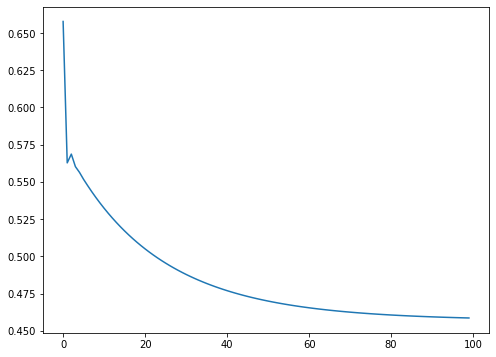

In [58]:
"""
Plot and display the progression of your loss values as a graph. Use the 
provided plotting functions.
"""

#begin_solution
print('Plot of the loss curve:')
plot_loss_curve(history)
#end_solution


In [59]:
#begin_test

#end_test


**Question 5.b**
<a name='question5b'></a>

Implementation of the Hinge Loss and its gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [60]:
def hinge_loss(z, Y):
    """
    Write your implementation of hinge loss here.

    Arguments:
    z : Classifier score
    Y : Label

    Returns:
    avg : The average hinge loss
    """

    #begin_solution

    avg = 0
    for (p, y) in zip(z, Y):
      avg += max(0, 1 - y * p)
    
    avg /= Y.shape[0]
    
    #end_solution


    return avg
  
def dhinge(preds,X, Y, W=[]):
    """
    Implement the derivative of hinge_loss here.

    Arguments:
    preds : The predicted values.
    X : Data matrix
    Y : True Labels
    W : Weights. Optional argument, may/may not be needed, depending on loss function
    Returns:
    J : Gradient of avg hinge_loss with respect to predicted values.
    """

    #begin_solution
    J = []

    for i in range(X.shape[1]):
      gradient = 0.0
      for (p, x, y) in zip(preds, X, Y):
        if Y[i] * preds[i] < 1:
          gradient -=  Y[i] * x[i]
      
      gradient /= len(preds)
      J.append(gradient)
      
    J = np.array(J)

    #end_solution

    
    return J

Implementation of the full gradient descent:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [61]:
"""
After implementing hinge_loss, dhinge and gd, test it below on the IRIS dataset.
"""

#begin_solution

history, best_w = gd(X_iris_bias, Y_iris_binary, W, hinge_loss, dhinge, 0.001, 100)

print('Values of the best weights: ', best_w)

#end_solution


At iteration: 0, the loss is: 0.6348460368576457
At iteration: 5, the loss is: 0.6236854211541171
At iteration: 10, the loss is: 0.6126148669730237
At iteration: 15, the loss is: 0.6016586190925438
At iteration: 20, the loss is: 0.590839849937108
At iteration: 25, the loss is: 0.5801804676612432
At iteration: 30, the loss is: 0.5697009493427148
At iteration: 35, the loss is: 0.5594202015997103
At iteration: 40, the loss is: 0.5493554500523719
At iteration: 45, the loss is: 0.5395221581654718
At iteration: 50, the loss is: 0.5299339751755053
At iteration: 55, the loss is: 0.5206027120543917
At iteration: 60, the loss is: 0.5145270621991143
At iteration: 65, the loss is: 0.5107216616083586
At iteration: 70, the loss is: 0.5070191784701522
At iteration: 75, the loss is: 0.5034441391192525
At iteration: 80, the loss is: 0.4999166890425719
At iteration: 85, the loss is: 0.4964371899393615
At iteration: 90, the loss is: 0.49486143823529943
At iteration: 95, the loss is: 0.4937588422773092
Va

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Plot of the loss curve:


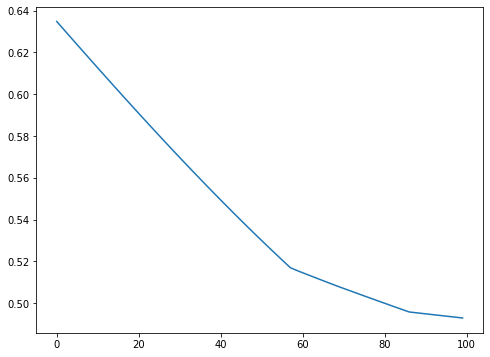

In [62]:
"""
Print the minimum loss
Plot and display the progression of loss. Use provided plotting functions
"""

#begin_solution
print('Plot of the loss curve:')
plot_loss_curve(history)
#end_solution


In [63]:
#begin_test

#end_test


**Question 5.c**
<a name='question5c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [64]:
def ksvm(kernel, X, Y, X_test):
    """
    Write your implementation of Kernel SVM here.

    Arguments:
    kernel : A callable function that takes 2 samples and returns the score
             for them.
    X : Training data matrix
    Y : Training Labels as -1/1
    X_test : Test data matrix

    Returns:
    support_vectors : The learned support vectors
    preds : The predicted labels as -1/1 on the given Test data
    """
    
    #begin_solution

    N = X.shape[0]
    C = 5  # scalar that controlls the importance of the right classification

    # Calculating the Gram matrix
    Gram = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
          Gram[i, j] = kernel(X[i], X[j])

    # Loss function for Lagrange dual problem
    def loss_lagrange(Gram, a):
      return np.sum(a) - 0.5 * np.dot(a, np.dot(a, Gram))

    # Gradient of the loss function
    def jac_lagrange(Gram, a):
      return np.ones_like(a) - np.dot(a, Gram)
    
    A = np.vstack((-np.eye(N), np.eye(N)))
    b = np.hstack((np.zeros(N), C * np.ones(N)))

    # Defining the following constraints:
    # -  a1 * y1 + a2 * y2 + ...  = 0
    # -  Ax <= B
    constraints = ({'type': 'eq', 'fun': lambda a: np.dot(a, Y),\
                    'jac': lambda a: Y},
                    {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a),\
                     'jac': lambda a: -A})

    # Compute the best lagrange multipliers by minimization with the oposite
    initial_guess = np.ones(N)  # defining an initial guess
    multipliers = optimize.minimize(fun=lambda a: -loss_lagrange(Gram, a),
                                x0=initial_guess, 
                                method='SLSQP', 
                                jac=lambda a: -jac_lagrange(Gram, a), 
                                constraints=constraints).x

    epsilon = 1e-5  # treshold for filtering relevant lagrange multipliers
    support_indices = multipliers > epsilon
    support_vectors = X[support_indices]
    support_multipliers = multipliers[support_indices]
    support_vector_labels = Y[support_indices]

    # Making predictions
    preds = []

    for x in X_test:
      result = 0.0
      for m_i, x_i, y_i in zip(support_multipliers, support_vectors, support_vector_labels):
        result += m_i * y_i * kernel(x_i, x)
      
      # the result of classification is the sign, meaning the position relative
      # to the support vectors
      preds.append(int(np.sign(result)))
    
    preds = np.array(preds)

    #end_solution


    return support_vectors, preds

In [65]:
X_iris_svm = np.copy(X_iris)
Y_iris_svm = np.copy(Y_iris)
Y_iris_svm[Y_iris==0] = -1
Y_iris_svm[Y_iris!=0] = 1

Y_iris_test_svm = np.copy(Y_iris_test)
Y_iris_test_svm[Y_iris_test==0] = -1
Y_iris_test_svm[Y_iris_test!=0] = 1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

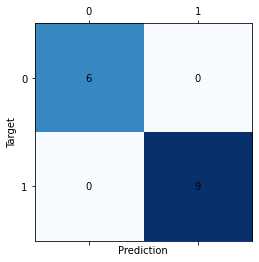

In [66]:
def kernel(x1, x2):
    """
    Define your kernel function here.

    Arguments:
    x1, x2 : Two data samples (vectors)

    Returns:
    score : The score between x1 and x2
    """

    #begin_solution

    # For the kernel function I chose a radial basis kernel because it
    # registered better results than a linear one
    gamma = 10
    score = np.exp(-gamma * np.linalg.norm(np.subtract(x1, x2)) ** 2)

    #end_solution


    return score

"""
After implementing ksvm and kernel, test it below on the IRIS dataset.
Print the accuracy of the model.
"""

#begin_solution

support_vectors, predictions = ksvm(kernel, X_iris_svm, Y_iris_svm, X_iris_test)
plot_confusion_matrix(Y_iris_test_svm, predictions)

#end_solution


In [67]:
#begin_test

#end_test


## 6. Neural Networks (20 points)
<a name='question6'></a>

[a)](#question6a) Devise a three-layer neural network with n hidden states and sigmoid activations for classification. Explain how many parameters this has in one sentence. (**2 points**)

[b)](#question6b) Implement the binary classifier nnclass(examplesA, examples, testExamples) that is trained with your implementation of (stochastic) GD and your gradient function using the network. (**5 points** + **7 points** on hidden dataset)

[c)](#question6c) Do an analysis how changes affect the accuracy with _MNIST_. Positive labels are assigned to digit 1 and negative samples to other digits. Write no longer than fifteen sentences. A table and / or plot is welcome. (**6 points**)

**Question 6.a**
<a name='question6a'></a>

_Your reply:_

&#9998; <font>
For my implementation I chose a neural network with 3 linear layers, each of them followed by a sigmoid activation layer. <br>The input has 784 parameters, the first layer will reduce the dimension to 300, the second layer to 100 and the final layer to only 1, because we need 1 output for our binary classifier (one that is 0 for the first class and 1 for the other). <br>Therefore the first layer in a matrix of 784 x 300 parameters, the second layer is a matrix of 300 x 100 parameters, and the third one is 100 x 1. <br> Therefore, the neural network will have 784 * 300 + 300 * 100 + 100 * 1 = 265300 parameters.
</font>

**Question 6.b**
<a name='question6b'></a>

In [68]:
def sigmoid(z):
    """
    Write your activation function here.

    Arguments:
    z : Scalar or batch of scalars on which to compute activation(s)

    Returns:
    activation : The activation value(s)
    """

    #begin_solution
    activation = []
    for pred in z:
      act = 1 / (1 + np.exp(-pred))
      act = np.minimum(act, 0.9999)
      act = np.maximum(act, 0.0001)
      activation.append(act)
    #end_solution


    return activation

def dsigmoid(z):
    """
    Implement the gradient of the activation function.

    Arguments:
    z : Scalar or batch of scalars

    Returns:
    gradient : Gradient(s) of the activation function
    """

    #begin_solution
    gradient = z * (1 - z)
    #end_solution


    return gradient

In [69]:
#begin_test

#end_test


Implementation of the forward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [70]:
def forward_pass(x, W, b):
    """
    Write your implementation of forward pass here.

    Arguments:
    x : Input data matrix
    W : Tuple of weight matrices
    b : Tuple of biases

    Returns:
    y_hat : Output of last layer
    cache : A tuple, that contains all intermediate outputs. These will be
            needed in your backward pass. Save anything in cache that you
            plan to use in the backward pass. It should be a tuple
    """

    #begin_solution
    
    x1 = (x @ W[0]) + b[0]  # linear forward
    a1 = np.array(sigmoid(x1))  # sigmoid forward

    x2 = (a1 @ W[1]) + b[1]  # linear forward
    a2 = np.array(sigmoid(x2))  # sigmoid forward
    
    x3 = (a2 @ W[2]) + b[2]  # linear forward
    a3 = np.array(sigmoid(x3))  # sigmoid forward

    y_hat = a3
    cache = (x, a1, a2)  # saving the inputs of every linear layer

    #end_solution


    return y_hat, cache

#begin_test

#end_test


Implementation of the loss and its associated gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [71]:
def loss(preds, targets):
    """
    Write your loss function here.

    Arguments:
    preds: The network predictions
    targets: The true labels

    Returns:
    cost: An error metric between pred and targets
    """

    #begin_solution

    # Cross-entropy for binar classifier
    m = len(preds)
    cost = 0.0
    for i in range(m):
      cost += -targets[i] * np.log(preds[i]) -\
              (1 - targets[i]) * np.log(1 - preds[i])
    cost /= m

    #end_solution

    
    return cost

def dloss(preds, target):
    """
    Write the derivative of loss function here.

    Arguments:
    preds : The network predictions
    target : The true labels

    Returns:
    gradient : The derivative of loss function with respect to the
              network outputs
    """

    #begin_solution
    
    gradient = -(1 / target.shape[0]) * ((target / preds) - ((1 - target)/(1 - preds)))

    #end_solution


    return gradient

In [72]:
#begin_test

#end_test


Implementation of the backward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [73]:
def backward_pass(preds, targets, W, b, X, cache):
    """
    Write your implementation of backward_pass here.

    Arguments:
    preds : The network predictions
    targets : The true labels
    W : A tuple of weight matrices
    b : A tuple of bias values
    X : Input data matrix
    cache : Tuple of Intermediate outputs that you cached in forward_pass

    Returns:
    Gradients with respect to each layer's weights and biases
    """

    def linear_backward(x, W, dy):
      dW = np.transpose(x) @ dy
      db = np.sum(dy, axis=0)

      return dW, db, dy @ np.transpose(W)
    
    #begin_solution

    dy = dloss(preds.squeeze(), targets.squeeze())
    dy = dy.reshape(dy.shape[0], 1)

    dx3 = dsigmoid(dy)  # sigmoid backward
    J_w3, J_b3, da2 = linear_backward(cache[2], W[2], dx3)  # linear backward
    
    dx2 = dsigmoid(da2)  # sigmoid backward
    J_w2, J_b2, da1 = linear_backward(cache[1], W[1], dx2)  # linear backward

    dx1 = dsigmoid(da1)  # sigmoid backward
    J_w1, J_b1, dx1 = linear_backward(cache[0], W[0], dx1)  # linear backward

    #end_solution

    
    return J_w3, J_w2, J_w1, J_b3, J_b2, J_b1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [74]:
def training(X, Y, W, b, step_size, max_it):
    """
    Implement your training loop here.

    Arguments:
    X : Input Data matrix
    Y : True labels
    W : A tuple of weight matrices
    step_size : The step size to take for network updates
    max_it : The maximum iterations after which to stop

    Returns:
    W : The trained weights
    b : The trained biases
    history : A list of your loss values at each iteration
    """
    
    #begin_test

    #end_test

    
    #begin_solution

    BATCH_SIZE = 300
    history = []
    for epoch in range(max_it):
      for i in range(0, X.shape[0], BATCH_SIZE):
        x = X[i: i + BATCH_SIZE, :]  # setting batch X
        targets = Y[i: i + BATCH_SIZE]  # setting batch Y
        targets.reshape(targets.shape[0], 1)

        preds, cache = forward_pass(x, W, b)
        loss_value = loss(preds.squeeze(), targets.squeeze())
        J_w3, J_w2, J_w1, J_b3, J_b2, J_b1 = \
                                  backward_pass(preds, targets, W, b, X, cache)

        # Gradient descent
        W[0] = W[0] - step_size * J_w1
        b[0] = b[0] - step_size * J_b1
        W[1] = W[1] - step_size * J_w2
        b[1] = b[1] - step_size * J_b2
        W[2] = W[2] - step_size * J_w3
        b[2] = b[2] - step_size * J_b3

      history.append(loss_value)

    #end_solution

    
    #begin_test

    #end_test

            
    return W, b, history

In [75]:
#begin_test

#end_test


Epoch 1, loss: 0.3929393055679971
Epoch 2, loss: 0.3908256761817907
Epoch 3, loss: 0.3851074835088765
Epoch 4, loss: 0.3720816241125314
Epoch 5, loss: 0.3500236193934979
Epoch 6, loss: 0.3273557805379614
Epoch 7, loss: 0.23623710110167462
Epoch 8, loss: 0.1823551545901334
Epoch 9, loss: 0.12256804356318232
Epoch 10, loss: 0.09942412086357094
Epoch 11, loss: 0.08618520624713154
Epoch 12, loss: 0.078550251359518
Epoch 13, loss: 0.07729921146043216
Epoch 14, loss: 0.07792331907397432
Epoch 15, loss: 0.07814558825423225
Epoch 16, loss: 0.07780904327783783
Epoch 17, loss: 0.07735315372188901
Epoch 18, loss: 0.07704297107902233
Epoch 19, loss: 0.0770332250626742
Epoch 20, loss: 0.07733907280099342


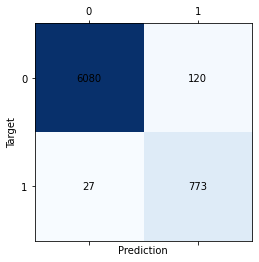

In [76]:
"""
Below, initialize the weights and biases randomly.
Start your training loop with your choice of parameters step_size, max_it
"""

#begin_solution
INPUT_SIZE = 784
HIDDEN_UNITS_1 = 300  # first layer output size
HIDDEN_UNITS_2 = 100  # second layer output size
OUTPUT_SIZE = 1    # third layer output size
EPOCHS = 20

# Data standardization
mean, std  = X_mnist.mean(), X_mnist.std()
X_mnist_nn = (X_mnist - mean) / std
X_mnist_test_nn = (X_mnist_test - mean) / std

Y_mnist_train_nn = np.copy(Y_mnist)
Y_mnist_train_nn[Y_mnist==1] = 1
Y_mnist_train_nn[Y_mnist!=1] = 0

Y_mnist_test_nn = np.copy(Y_mnist_test)
Y_mnist_test_nn[Y_mnist_test==1] = 1
Y_mnist_test_nn[Y_mnist_test!=1] = 0

np.random.seed(100)

w1 = np.random.uniform(-0.01, 0.01, (INPUT_SIZE, HIDDEN_UNITS_1))
w2 = np.random.uniform(-0.01, 0.01, (HIDDEN_UNITS_1, HIDDEN_UNITS_2))
w3 = np.random.uniform(-0.01, 0.01, (HIDDEN_UNITS_2, OUTPUT_SIZE))
W = np.array([w1, w2, w3], dtype=object)

b1 = np.random.uniform(-0.01, 0.01, (HIDDEN_UNITS_1,))
b2 = np.random.uniform(-0.01, 0.01, (HIDDEN_UNITS_2,))
b3 = np.random.uniform(-0.01, 0.01, (OUTPUT_SIZE,))
b = np.array([b1, b2, b3], dtype=object)

W, b, history = \
training(X_mnist_nn, Y_mnist_train_nn, W, b, step_size=0.001, max_it=EPOCHS)

for epoch in range(EPOCHS):
  print('Epoch {}, loss: {}'.format(epoch + 1, history[epoch]))

predictions, _ = forward_pass(X_mnist_test_nn, W, b)

for i in range(predictions.shape[0]):  #classifying the predictions
  if predictions[i] >= 0.5:
    predictions[i] = 1
  else:
    predictions[i] = 0

plot_confusion_matrix(Y_mnist_test_nn, predictions.squeeze().astype(int))

#end_solution




**Question 6.c**
<a name='question6d'></a>

&#9998; <font>
By varying the parameters I observed that standardization is a key factor for a good prediction, as digits tend to vary their position inside images.<br>
A second observation is that the bigger the batch size, the better, but from a certain number the accuracy varies just a little. For example, the loss for a batch size of 300 is 0.077 whereas for 500 elements inside the batch the loss in 0.069. However, the difference is big from 100 to 300 elemets inside a batch, predicting with a loss of 0.36 in the first mentioned case.
<br>
Looking at the number of iterations (epochs) we observe that 20 epochs are better than 10 epochs and just a little bit worse than 30 epochs. A small number of epochs could lead to underfitting, while a great number of epochs could lead to overfitting.
<br>
Speaking of the learning step size, a small one is prefferable, but it is more time expensive, because it would take a greater number of epochs to reach the best weights.
<br>
Underneath I attached results for: no data standardization, 100 batch size, 500 batch size, 10 epochs, 30 epochs and 0.0005 learning step size.
<br>

Results of the neural network without data standardization:<br>
![picture](https://drive.google.com/uc?export=view&id=1Zaixs3dIvj29XhX2I1ydhk4_oFKQXffe)
<br><br>
Results of the neural network with batch size 100:<br>
![picture](https://drive.google.com/uc?export=view&id=1G3LIXZerjE3_STlqmx0dCr7nnzsWnV-a)
<br><br>
Results of the neural network with batch size 500:<br>
![picture](https://drive.google.com/uc?export=view&id=1GXBphoJyREDkJ6WDH4eU2helZRC2zsAh)
<br><br>
Results of the neural network with 10 epochs:<br>
![picture](https://drive.google.com/uc?export=view&id=1BxqyS2F30tC_KE1TdsHe3MWQivvcbr9a)
<br><br>
Results of the neural network with 30 epochs:<br>
![picture](https://drive.google.com/uc?export=view&id=10wzrsVUiA1L1T2Ojzq8189RsNNb8IiLq)
<br><br>
Results of the neural network with 0.0005 learning step:<br>
![picture](https://drive.google.com/uc?export=view&id=1BN__1GH8oHAq3cNcxKJ_9a0vhx_KPB6g)

</font>

_Your reply:_

In [77]:
#begin_test

#end_test
